In [ ]:
import sys
import os

utils_path = os.path.abspath('..')
sys.path.append(utils_path)

# Feature Planning/Engineering

This notebook will serve to check and test different ideas for the features to be created from the dataset for the noise event prediction

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from utils import *

In [2]:
df = pd.read_parquet('../data/pred_model_data_full.parquet')

In [3]:
df.shape

(77232, 36)

In [4]:
df.columns

Index(['#object_id', 'noise_event_laeq_model_id',
       'noise_event_laeq_primary_detected_certainty',
       'noise_event_laeq_primary_detected_class', 'date', 'hour', 'minute',
       'second', 'LC_RAININ', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL3',
       'lamax', 'laeq', 'lceq', 'lcpeak', 'lamax_shift_t-_1',
       'laeq_shift_t-_1', 'lceq_shift_t-_1', 'lcpeak_shift_t-_1',
       'lamax_shift_t-_2', 'laeq_shift_t-_2', 'lceq_shift_t-_2',
       'lcpeak_shift_t-_2', 'lamax_shift_t-_3', 'laeq_shift_t-_3',
       'lceq_shift_t-_3', 'lcpeak_shift_t-_3', 'lamax_shift_t-_4',
       'laeq_shift_t-_4', 'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
       'lamax_shift_t-_5', 'laeq_shift_t-_5', 'lceq_shift_t-_5',
       'lcpeak_shift_t-_5'],
      dtype='object')

## Columns to drop:

- 'noise_event_laeq_model_id',
- 'minute',
- 'second'

These columns will not be used for predicting the noise event, as they most likely do not contribute to the target's class.

---
## "#object_id"

In [5]:
df['#object_id'].value_counts()

#object_id
255439    25088
255444    21306
255442    10394
255443     9191
255441     6727
255440     4133
280324      393
Name: count, dtype: int64

This column represents the location in which the noise was recorded, and can be a factor of influence in the noise type (e.g a location closer to bars and parties can have a higher chance of detecting human voices and screams).

---
## "noise_event_laeq_primary_detected_certainty"

In [6]:
df.noise_event_laeq_primary_detected_certainty.describe()

count    77232.000000
mean        67.537692
std         42.004351
min          0.000000
25%          0.000000
50%         91.000000
75%         99.000000
max        100.000000
Name: noise_event_laeq_primary_detected_certainty, dtype: float64

This column represents the certainty that the creators of the noise events dataset have when labeling the event. It is in a percent format, and needs to be divided by 100.

In [7]:
df.groupby('noise_event_laeq_primary_detected_class')['noise_event_laeq_primary_detected_certainty'].mean()

noise_event_laeq_primary_detected_class
Human voice - Shouting            89.096482
Human voice - Singing             91.344732
Music non-amplified               71.531746
Nature elements - Wind            84.451327
Transport road - Passenger car    93.192272
Transport road - Siren            85.883032
Unsupported                        0.000000
Name: noise_event_laeq_primary_detected_certainty, dtype: float64

Since the 'unsupported' label has 0% certainty in all observations, we cannot use the certainty as weights in a tree based model, because all 'unsupported' observations would have zero weight, and that class would never be the predicted output, so it is better to use this variable in the model evaluation instead.

Only possible to use the certainty as weights in a tree based model if we remove the 'unsupported' labeled observations from the dataset.

---
## Time Features

Use the hour column to create the 'period_of_day' feature 
(dawn, morning, afternoon, night)

In [8]:
df.hour.describe()

count    77232.000000
mean        11.675407
std          5.747171
min          0.000000
25%          8.000000
50%         11.000000
75%         16.000000
max         23.000000
Name: hour, dtype: float64

In [9]:
dpt = DayPeriodHandler()

df = dpt.fit_transform(df)

df[['hour', 'day_period']].sample(n=df.shape[0]).head(15)

,hour,day_period
36559,17,afternoon
43199,5,dawn
16463,10,morning
9429,20,night
67728,8,morning
26209,17,afternoon
68974,8,morning
7970,11,morning
1295,14,afternoon
47242,4,dawn


Use the date column to get the months and days of the week:
- for months, test using all months as categories or grouped by season (12-2, 3-5, 6-8, 9-11)

- for days of the week, test using all as categories or grouped by weekend or weekdays (maybe grouping friday with weekend)

In [10]:
mt = MonthHandler(strategy='month')

df = mt.fit_transform(df)

df[['date', 'month']].sample(n=df.shape[0]).head(15)

,date,month
47861,2022-05-24,5
5199,2022-04-27,4
61322,2022-11-16,11
2479,2022-04-22,4
54036,2022-05-24,5
49806,2022-05-30,5
53217,2022-05-21,5
51584,2022-05-13,5
60071,2022-11-07,11
5044,2022-04-21,4


In [11]:
wdt1 = DayoftheWeekHandler(strategy='full')
wdt2 = DayoftheWeekHandler(strategy='weekend')

df = wdt1.fit_transform(df)
df.rename(columns={'weekday': 'full_weekday'}, inplace=True)
df = wdt2.fit_transform(df)

df[['full_weekday', 'weekday']].sample(n=df.shape[0]).head(15)

,full_weekday,weekday
46021,4,weekend
26971,4,weekend
66470,0,weekday
40152,2,weekday
7330,1,weekday
8399,1,weekday
20386,6,weekend
59029,1,weekday
18776,4,weekend
36803,1,weekday


In [12]:
df.drop(columns=['weekday'], inplace=True)

---
## Dropping all unecessary columns to this point

In [13]:
cdt = ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty']
    )

df = cdt.fit_transform(df)

In [14]:
df.columns

Index(['#object_id', 'noise_event_laeq_primary_detected_class', 'LC_RAININ',
       'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL3', 'lamax', 'laeq', 'lceq',
       'lcpeak', 'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
       'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
       'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
       'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
       'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
       'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
       'lceq_shift_t-_5', 'lcpeak_shift_t-_5', 'day_period', 'month',
       'full_weekday'],
      dtype='object')

---

## Numeric Meteo features:

- Temperature at QLC3
- LC_RAD60 (radiation, weighted average on the hour)
- LC_RAININ (rain intensity)
- LC_WINDSPEED (wind speed)

They can be used as they are, since we are using tree based models and they are robust to feature scales.

In [15]:
df[['LC_RAININ', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL3']].describe()

,LC_RAININ,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL3
count,77232.000000,77232.000000,77232.000000,77232.000000
mean,0.000136,0.296962,138.636275,15.165546
std,0.001318,0.298072,155.677160,7.418431
min,0.000000,0.000000,0.009524,-8.137261
25%,0.000000,0.065243,0.059406,10.085690
50%,0.000000,0.222788,80.514851,15.111820
75%,0.000000,0.438837,238.242105,20.014067
max,0.054769,3.387553,573.094340,38.619877


---

## Check the Encoding of the Categorical Features

The categorical features at this point are:

- '#object_id'
- 'day_period'
- 'month'
- 'weekday'

In [16]:
enc = CustomEncoder(
    columns=['#object_id', 'day_period', 'month', 'full_weekday'],
    strategy='one_hot')

df = enc.fit_transform(df)

In [17]:
df.columns

Index(['noise_event_laeq_primary_detected_class', 'LC_RAININ', 'LC_WINDSPEED',
       'LC_RAD60', 'LC_TEMP_QCL3', 'lamax', 'laeq', 'lceq', 'lcpeak',
       'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
       'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
       'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
       'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
       'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
       'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
       'lceq_shift_t-_5', 'lcpeak_shift_t-_5', '#object_id_255439',
       '#object_id_255440', '#object_id_255441', '#object_id_255442',
       '#object_id_255443', '#object_id_255444', 'day_period_afternoon',
       'day_period_morning', 'day_period_night', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'full_weekday_0', 'full_weekday_1',
       'full_weekday

---

## Noise Levels

For the Noise levels, use PCA to lower the dimension. Test different scenarios:

- one PCA per timestep
- one PCA per noise type
- one PCA for all

use a threshold for 90% explained variance and check which method needs the least amount of components.

In [18]:
# import the pca module from sklearn
from sklearn.decomposition import PCA

# create 3 pca objects for the different scenarios that use all the principal components
pca_pts = PCA()
pca_pnt = PCA()
pca_tot = PCA()

### PCA per timestep 

In [19]:
# fit a pca on the first timestep features
pca_pts.fit(df[[
    'lamax',
    'laeq',
    'lceq',
    'lcpeak'
]])
    

# get the number of comps that sum an explained variance ratio <= 0.9
np.cumsum(pca_pts.explained_variance_ratio_)

array([0.77990016, 0.96573728, 0.99537809, 1.        ])

timestep 0 requires 2 components

In [20]:
# fit a pca on the second timestep features
pca_pts.fit(df[[
    'lamax_shift_t-_1',
    'laeq_shift_t-_1',
    'lceq_shift_t-_1',
    'lcpeak_shift_t-_1'
]])
    
    

# get the number of comps that sum an explained variance ratio <= 0.9
np.cumsum(pca_pts.explained_variance_ratio_)

array([0.80967864, 0.96287872, 0.99124463, 1.        ])

timestep -1 requires 2 components

In [21]:
# fit a pca on the third timestep features
pca_pts.fit(df[[
    'lamax_shift_t-_2',
    'laeq_shift_t-_2',
    'lceq_shift_t-_2',
    'lcpeak_shift_t-_2'
]])
    
    

# get the number of comps that sum an explained variance ratio <= 0.9
np.cumsum(pca_pts.explained_variance_ratio_)

array([0.79085675, 0.95424596, 0.98854719, 1.        ])

timestep -2 requires 2 components

In [22]:
# fit a pca on the fourth timestep features
pca_pts.fit(df[[
    'lamax_shift_t-_3',
    'laeq_shift_t-_3',
    'lceq_shift_t-_3',
    'lcpeak_shift_t-_3'
]])
    
    

# get the number of comps that sum an explained variance ratio <= 0.9
np.cumsum(pca_pts.explained_variance_ratio_)

array([0.83662204, 0.96082358, 0.98721306, 1.        ])

timestep -3 requires 2 components

In [23]:
# fit a pca on the fifth timestep features
pca_pts.fit(df[[
    'lamax_shift_t-_4',
    'laeq_shift_t-_4',
    'lceq_shift_t-_4',
    'lcpeak_shift_t-_4'
]])
    
    

# get the number of comps that sum an explained variance ratio <= 0.9
np.cumsum(pca_pts.explained_variance_ratio_)

array([0.87298427, 0.97310277, 0.99119931, 1.        ])

timestep -4 requires 2 components

In [24]:
# fit a pca on the sixth timestep features
pca_pts.fit(df[[
    'lamax_shift_t-_5',
    'laeq_shift_t-_5',
    'lceq_shift_t-_5',
    'lcpeak_shift_t-_5'
]])
    
    

# get the number of comps that sum an explained variance ratio <= 0.9
np.cumsum(pca_pts.explained_variance_ratio_)

array([0.89061591, 0.97863218, 0.99310901, 1.        ])

timestep -5 requires 2 components

In total the PCA per timestep requires 12 components

### PCAs per noise type

In [25]:
# fit a pca on the lamax features
pca_pnt.fit(df[[
    'lamax',
    'lamax_shift_t-_1',
    'lamax_shift_t-_2',
    'lamax_shift_t-_3',
    'lamax_shift_t-_4',
    'lamax_shift_t-_5']])

# get the number of comps that sum an explained variance ratio <= 0.9
np.cumsum(pca_pnt.explained_variance_ratio_)

array([0.43482941, 0.79357919, 0.90780829, 0.95375955, 0.98272068,
       1.        ])

lamax requires 3 components

In [26]:
# fit a pca on the laeq features
pca_pnt.fit(df[[
    'laeq',
    'laeq_shift_t-_1',
    'laeq_shift_t-_2',
    'laeq_shift_t-_3',
    'laeq_shift_t-_4',
    'laeq_shift_t-_5']])

# get the number of comps that sum an explained variance ratio <= 0.9
np.cumsum(pca_pnt.explained_variance_ratio_)

array([0.50864515, 0.78243069, 0.89668006, 0.94296157, 0.9758474 ,
       1.        ])

laeq requires 4 components

In [27]:
# fit a pca on the lceq features
pca_pnt.fit(df[[
    'lceq',
    'lceq_shift_t-_1',
    'lceq_shift_t-_2',
    'lceq_shift_t-_3',
    'lceq_shift_t-_4',
    'lceq_shift_t-_5']])


# get the number of comps that sum an explained variance ratio <= 0.9
np.cumsum(pca_pnt.explained_variance_ratio_)

array([0.65462855, 0.84586239, 0.92378124, 0.95881361, 0.9822279 ,
       1.        ])

lceq requires 3 components

In [28]:
# fit a pca on the lcpeak features
pca_pnt.fit(df[[
    'lcpeak',
    'lcpeak_shift_t-_1',
    'lcpeak_shift_t-_2',
    'lcpeak_shift_t-_3',
    'lcpeak_shift_t-_4',
    'lcpeak_shift_t-_5']])

# get the number of comps that sum an explained variance ratio <= 0.9
np.cumsum(pca_pnt.explained_variance_ratio_)

array([0.52821008, 0.79465634, 0.89324376, 0.93894959, 0.97362616,
       1.        ])

lcpeak requires 4 components

In total the PCA per noisetype requires 14 components

### PCA for all

In [29]:
# fit a pca on all noise features
pca_tot.fit(df[[
    'lamax', 'laeq', 'lceq', 'lcpeak',
    'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
    'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
    'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
    'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
    'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
    'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
    'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
]])

# get the number of comps that sum an explained variance ratio <= 0.9
np.cumsum(pca_tot.explained_variance_ratio_)

array([0.43851181, 0.68220678, 0.77659327, 0.86966556, 0.90719222,
       0.93224096, 0.94993456, 0.96132067, 0.97080717, 0.9761582 ,
       0.97946125, 0.98251173, 0.98526496, 0.9876083 , 0.98969419,
       0.99158079, 0.99328157, 0.99478966, 0.99615942, 0.99722592,
       0.99817741, 0.99896627, 0.99956839, 1.        ])

For the PCA on all noise levels, we only need 5 components to get 90% explained variance.

We can even choose to get 7 components to obtain 95% explained variance.

In [30]:
pcat = PCATransformer(
    n_components=7,
    columns=[
        'lamax', 'laeq', 'lceq', 'lcpeak',
        'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
        'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
        'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
        'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
        'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
        'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
        'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
    ]
)

df = pcat.fit_transform(df)

In [31]:
df.columns

Index(['noise_event_laeq_primary_detected_class', 'LC_RAININ', 'LC_WINDSPEED',
       'LC_RAD60', 'LC_TEMP_QCL3', '#object_id_255439', '#object_id_255440',
       '#object_id_255441', '#object_id_255442', '#object_id_255443',
       '#object_id_255444', 'day_period_afternoon', 'day_period_morning',
       'day_period_night', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'full_weekday_0', 'full_weekday_1', 'full_weekday_2',
       'full_weekday_3', 'full_weekday_4', 'full_weekday_5',
       'noise_lvl_comp_1', 'noise_lvl_comp_2', 'noise_lvl_comp_3',
       'noise_lvl_comp_4', 'noise_lvl_comp_5', 'noise_lvl_comp_6',
       'noise_lvl_comp_7'],
      dtype='object')

---
## First test run on a Random Forest model

In [32]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [33]:
df.noise_event_laeq_primary_detected_class.value_counts()

noise_event_laeq_primary_detected_class
Transport road - Passenger car    47386
Unsupported                       20791
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Music non-amplified                 126
Nature elements - Wind              113
Name: count, dtype: int64

In [34]:
#df = df[df['noise_event_laeq_primary_detected_class'] != 'Unsupported']

In [35]:
X = df.drop(columns=['noise_event_laeq_primary_detected_class'])

le = LabelEncoder()

y = le.fit_transform(df[['noise_event_laeq_primary_detected_class']])

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=1)

#sm = SMOTE(random_state=1)

#X_train, y_train = sm.fit_resample(X_train, y_train)

c:\Users\guibl\MDA-Project\.venv\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
# Calculate the class weights based on the proportions in the target
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([ 1.89711198, 10.57964775, 82.16109422, 89.80398671,  0.23343336,
        5.63733055,  0.52804204])

In [37]:
le.classes_

array(['Human voice - Shouting', 'Human voice - Singing',
       'Music non-amplified', 'Nature elements - Wind',
       'Transport road - Passenger car', 'Transport road - Siren',
       'Unsupported'], dtype=object)

In [38]:
rf = RandomForestClassifier(n_estimators=200, random_state=1, min_samples_leaf=15, class_weight='balanced')

In [39]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=15,
                       n_estimators=200, random_state=1)

In [41]:
y_pred = rf.predict(X_val)

In [42]:
y_pred_proba = rf.predict_proba(X_val)

In [43]:
(y_pred == y_val).mean()

0.7006042296072508

In [44]:
balanced_accuracy_score(y_val, y_pred)

0.5325235864237251

In [45]:
roc_auc_score(y_val, y_pred_proba, multi_class='ovo')

0.8924301164443731

In [46]:
cm = confusion_matrix(y_val, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

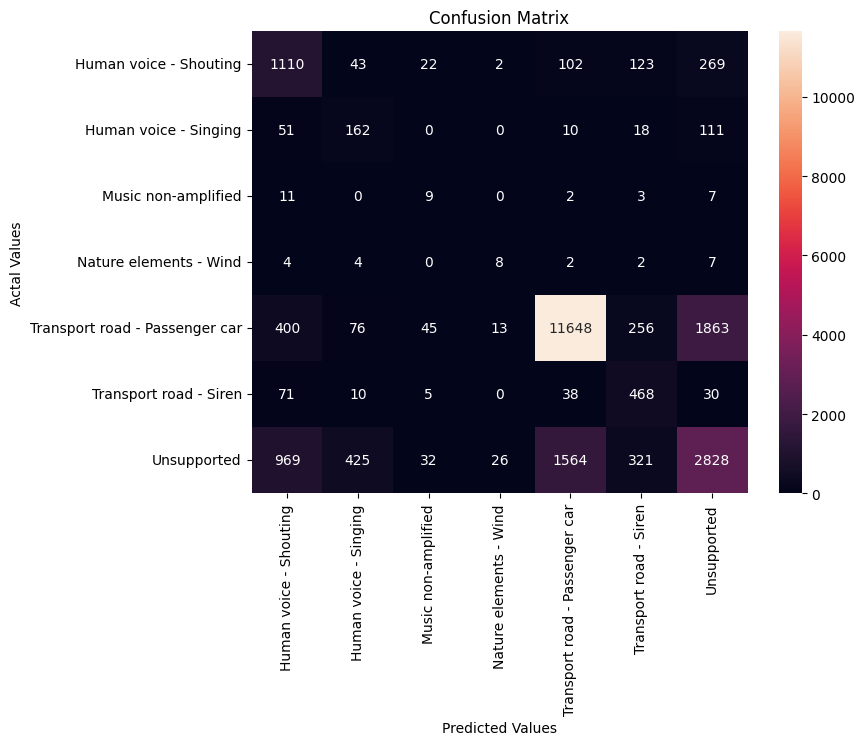

In [47]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')


plt.show()

In [48]:
print(classification_report(y_val, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.42      0.66      0.52      1671
         Human voice - Singing       0.23      0.46      0.30       352
           Music non-amplified       0.08      0.28      0.12        32
        Nature elements - Wind       0.16      0.30      0.21        27
Transport road - Passenger car       0.87      0.81      0.84     14301
        Transport road - Siren       0.39      0.75      0.52       622
                   Unsupported       0.55      0.46      0.50      6165

                      accuracy                           0.70     23170
                     macro avg       0.39      0.53      0.43     23170
                  weighted avg       0.73      0.70      0.71     23170



Test a model only to predict if noise is wind or not

In [49]:
df['noise_event_laeq_primary_detected_class'] = np.where(df['noise_event_laeq_primary_detected_class'] != 'Nature elements - Wind', 'Other', df['noise_event_laeq_primary_detected_class'])

In [50]:
X = df.drop(columns=['noise_event_laeq_primary_detected_class'])

le = LabelEncoder()

y = le.fit_transform(df[['noise_event_laeq_primary_detected_class']])

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=1)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1)

X_train, y_train = sm.fit_resample(X_train, y_train)

c:\Users\guibl\MDA-Project\.venv\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
# Calculate the class weights based on the proportions in the target
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([1., 1.])

In [52]:
le.classes_

array(['Nature elements - Wind', 'Other'], dtype=object)

In [53]:
pd.Series(y_train).value_counts()

1    61690
0    61690
Name: count, dtype: int64

In [54]:
rf = RandomForestClassifier(n_estimators=300, random_state=1, min_samples_leaf=5)

In [55]:
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=300, random_state=1)

In [56]:
y_pred_proba = rf.predict_proba(X_val)

In [57]:
y_pred_proba

array([[4.16666667e-04, 9.99583333e-01],
       [8.33333333e-04, 9.99166667e-01],
       [9.43801121e-03, 9.90561989e-01],
       ...,
       [3.32868649e-03, 9.96671314e-01],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00]])

0.99

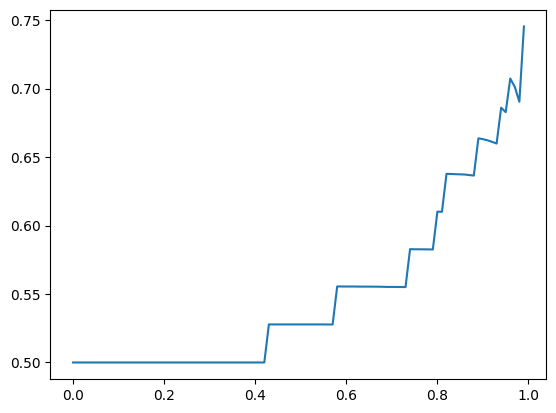

In [58]:
# Find the optimal threshold for maximum balanced accuracy

thresholds = np.arange(0.0, 1.0, 0.01)

balanced_accuracy = []

for t in thresholds:
    y_pred = np.where(y_pred_proba[:,1] > t, 1, 0)
    balanced_accuracy.append(balanced_accuracy_score(y_val, y_pred))

balanced_accuracy = np.array(balanced_accuracy)


plt.plot(thresholds, balanced_accuracy)

# get the threshold of the maximum balaced accuracy
thresholds[np.argmax(balanced_accuracy)]

In [59]:
y_pred = np.where(y_pred_proba[:,1] > 0.98, 1, 0)

In [60]:
y_pred = rf.predict(X_val)

In [61]:
(y_pred == y_val).mean()

0.9988994626788373

In [62]:
roc_auc_score(y_val, y_pred_proba[:,1])

0.9017020617740042

In [63]:
cm = confusion_matrix(y_val, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

In [64]:
# check the y_val value counts
pd.Series(y_val).value_counts()

1    15429
0       18
Name: count, dtype: int64

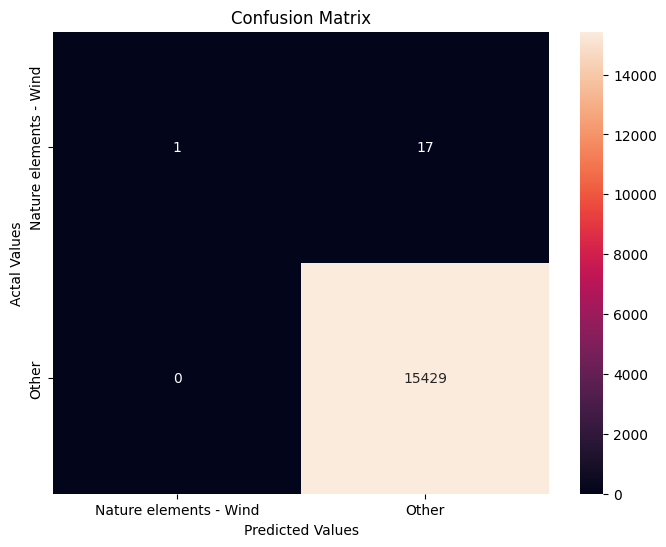

In [65]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')


plt.show()

In [66]:
print(classification_report(y_val, y_pred, target_names=classes))

                        precision    recall  f1-score   support

Nature elements - Wind       1.00      0.06      0.11        18
                 Other       1.00      1.00      1.00     15429

              accuracy                           1.00     15447
             macro avg       1.00      0.53      0.55     15447
          weighted avg       1.00      1.00      1.00     15447

